In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer

import lightgbm as lgb

pd.set_option('display.max_columns', None)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [3]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [4]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col) for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

In [6]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            #year_decision = pl.col("date_decision").dt.year(),
            month_decision = pl.col("date_decision").dt.month(),
            #week_decision = pl.col("date_decision").dt.week(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [7]:
def preprocess_data(data, features, imputer):
    data[features] = imputer.transform(data[features])
    return data

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [9]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [10]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [11]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 473)


In [12]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [13]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 472)


In [14]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 362)
test data shape:	 (10, 361)


In [15]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [16]:
selected_features = ['pmtamount_36A', 'amount_4527230A', 'amount_4917619A', 'eir_270L']

imputer = SimpleImputer(strategy='constant', fill_value=0)
df_train[selected_features] = imputer.fit_transform(df_train[selected_features])

df_test = preprocess_data(df_test, selected_features, imputer)

In [17]:
del data_store

gc.collect()

0

In [18]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


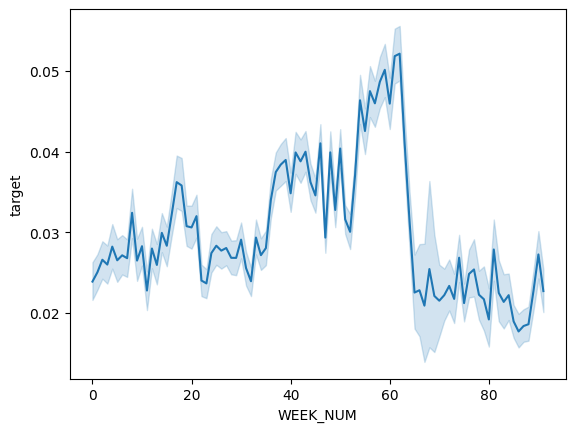

In [19]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

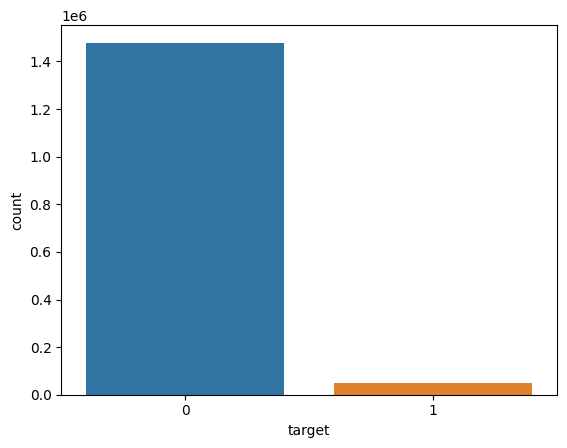

In [20]:
sns.countplot(x='target', data=df_train)
plt.show()

In [21]:
a1 = df_train.loc[df_train['target'] == 0, 'amount_4527230A'].value_counts().loc[0] / len(df_train[df_train['target'] == 0])
a2 = df_train.loc[df_train['target'] == 1, 'amount_4527230A'].value_counts().loc[0] / len(df_train[df_train['target'] == 1])

display(df_train.loc[df_train['target'] == 0, 'amount_4527230A'].shape)
display(a1)
print('------------------')
display(df_train.loc[df_train['target'] == 1, 'amount_4527230A'].shape)
display(a2)

(1478665,)

0.7024004761051353

------------------


(47994,)

0.627495103554611

In [22]:
b1 = df_train.loc[df_train['target'] == 0, 'pmtamount_36A'].value_counts().loc[0] / len(df_train[df_train['target'] == 0])
b2 = df_train.loc[df_train['target'] == 1, 'pmtamount_36A'].value_counts().loc[0] / len(df_train[df_train['target'] == 1])

display(df_train.loc[df_train['target'] == 0, 'pmtamount_36A'].shape)
display(b1)
print('------------------')
display(df_train.loc[df_train['target'] == 1, 'pmtamount_36A'].shape)
display(b2)

(1478665,)

0.6834110498321121

------------------


(47994,)

0.7054840188356878

In [23]:
c1 = df_train.loc[df_train['target'] == 0, 'amount_4917619A'].value_counts().loc[0] / len(df_train[df_train['target'] == 0])
c2 = df_train.loc[df_train['target'] == 1, 'amount_4917619A'].value_counts().loc[0] / len(df_train[df_train['target'] == 1])

display(df_train.loc[df_train['target'] == 0, 'amount_4917619A'].shape)
display(c1)
print('------------------')
display(df_train.loc[df_train['target'] == 1, 'amount_4917619A'].shape)
display(c2)

(1478665,)

0.9007618358451711

------------------


(47994,)

0.9168229362003584

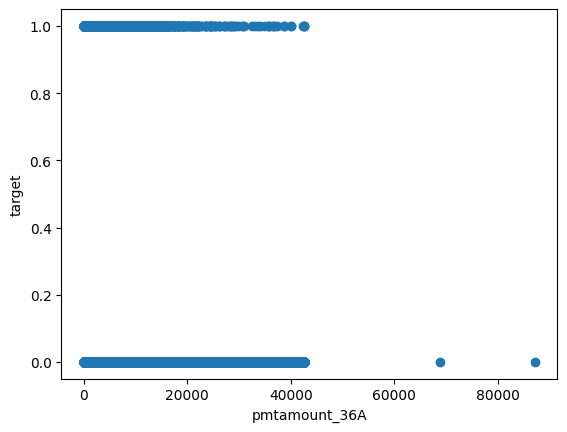

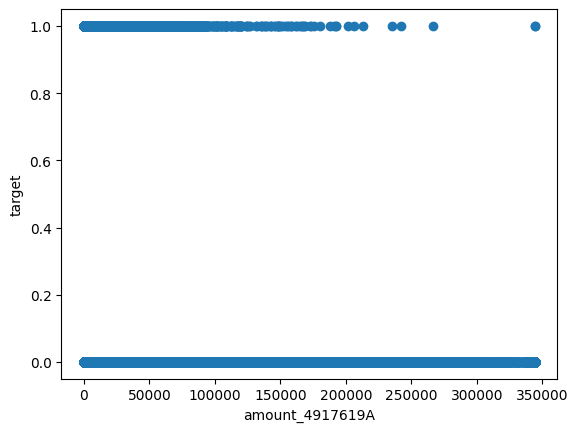

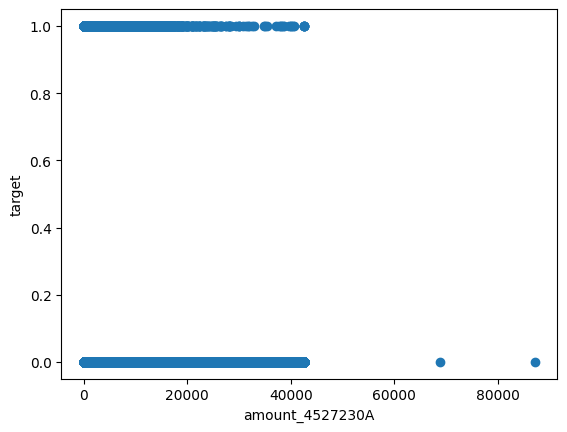

In [24]:
for col in ['pmtamount_36A', 'amount_4917619A', 'amount_4527230A']:
    plt.scatter(df_train[col], df_train["target"])
    plt.xlabel(col)
    plt.ylabel("target")
    plt.show()

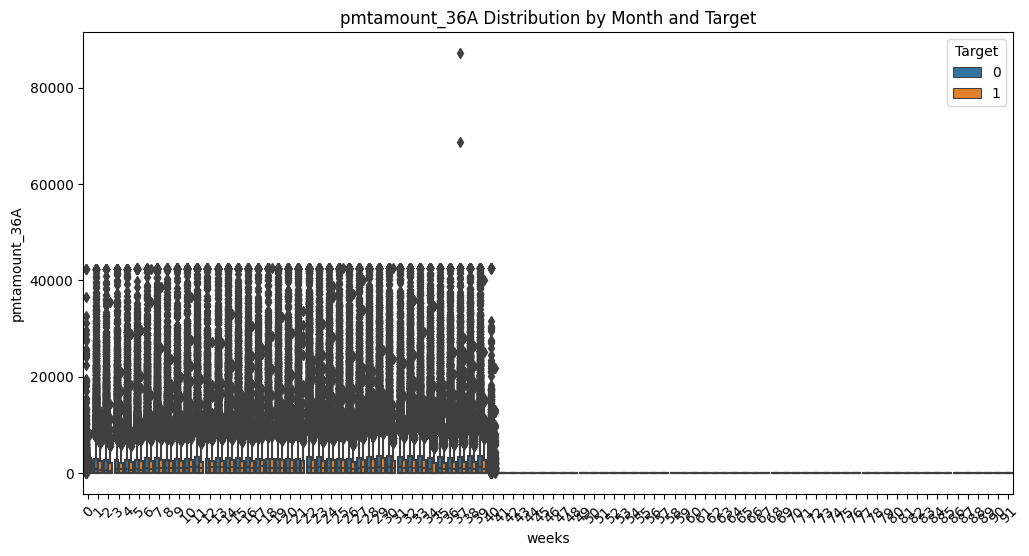

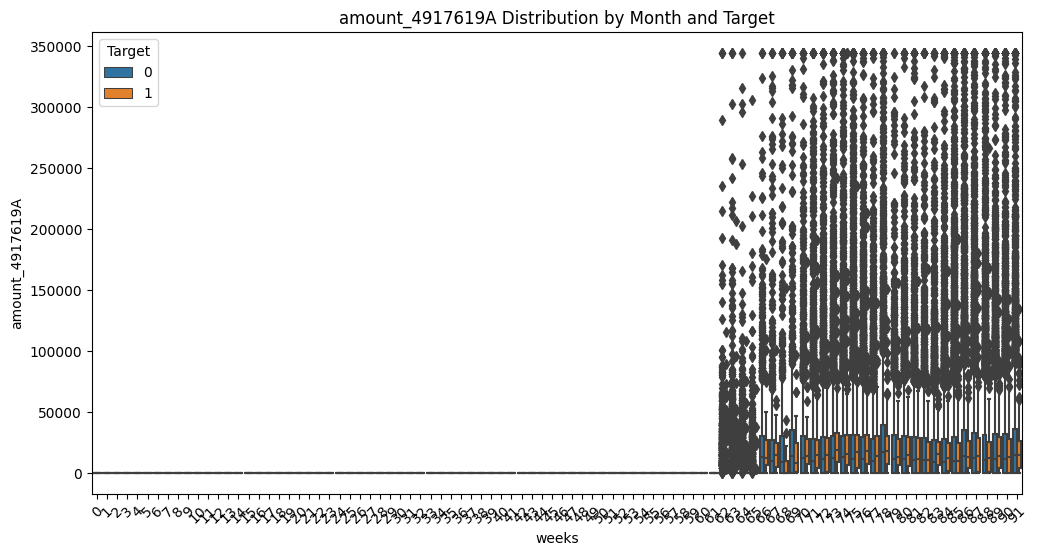

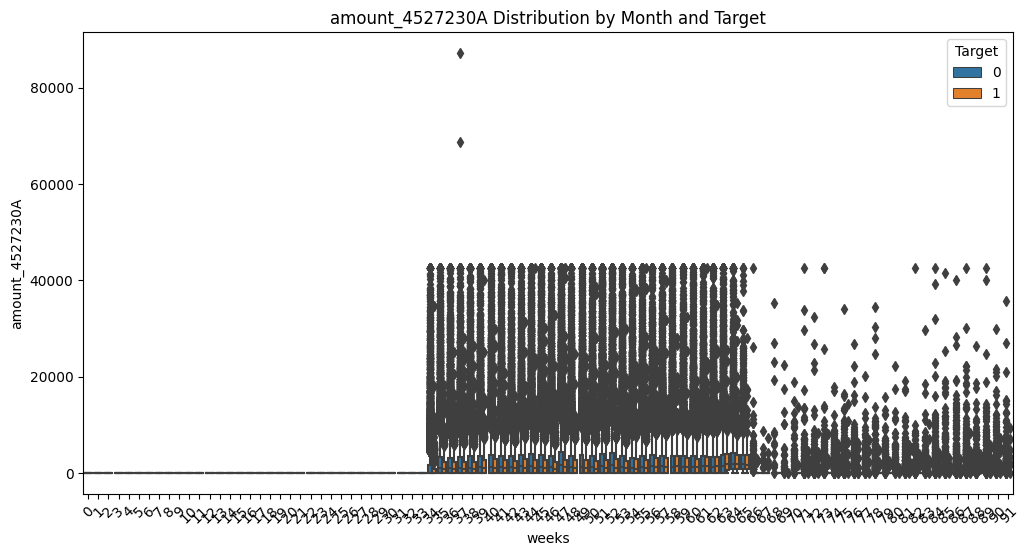

In [25]:
for col in ['pmtamount_36A', 'amount_4917619A', 'amount_4527230A']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='WEEK_NUM', y=col, hue='target', data=df_train)
    plt.xlabel('weeks')
    plt.ylabel(col)
    plt.title(f'{col} Distribution by Month and Target')
    plt.xticks(rotation=45)
    plt.legend(title='Target')
    plt.show()

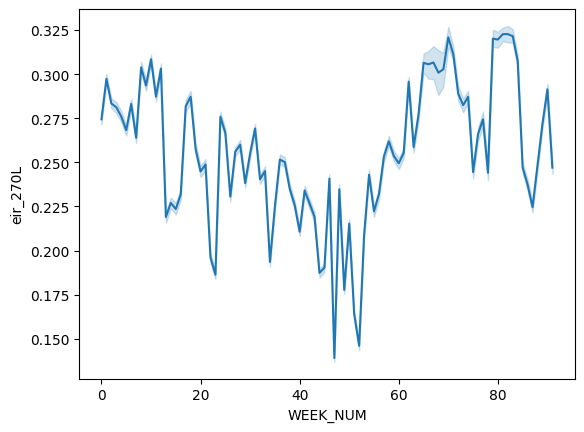

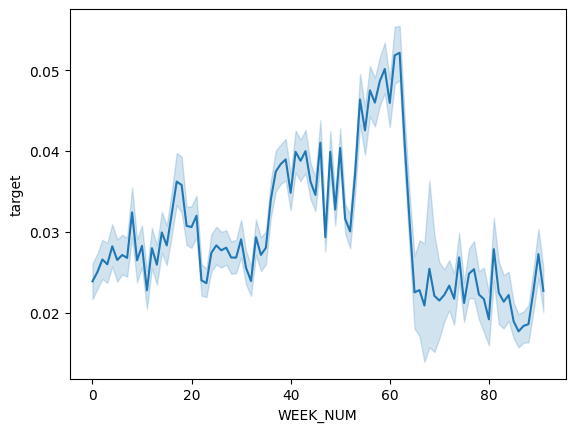

In [26]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="eir_270L",
)
plt.show()

sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [27]:
df_train['eir_270L_trend'] = df_train['eir_270L'].rolling(window=4).mean()  # Moving average
df_train['eir_270L_volatility'] = df_train['eir_270L'].rolling(window=4).std()  # Volatility
df_train['eir_270L_lag_1'] = df_train['eir_270L'].shift(1)  # Lag feature
#df_train['eir_270L_lag_2'] = df_train['eir_270L'].shift(2)  # Another lag feature
df_train['rate_of_change'] = df_train['eir_270L'].pct_change()  # Rate of change

In [28]:
df_test['eir_270L_trend'] = df_train['eir_270L'].rolling(window=4).mean()  # Moving average
df_test['eir_270L_volatility'] = df_train['eir_270L'].rolling(window=4).std()  # Volatility
df_test['eir_270L_lag_1'] = df_train['eir_270L'].shift(1)  # Lag feature
#df_test['eir_270L_lag_2'] = df_train['eir_270L'].shift(2)  # Another lag feature
df_test['rate_of_change'] = df_train['eir_270L'].pct_change()  # Rate of change

In [29]:
df_train['median_pmtamount'] = df_train[['pmtamount_36A', 'amount_4527230A', 'amount_4917619A']].median(axis=1)
df_test['median_pmtamount'] = df_test[['pmtamount_36A', 'amount_4527230A', 'amount_4917619A']].median(axis=1)

In [30]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM", "date_decision"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False) # n=5

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.1,
    "n_estimators": 1000, # n=1000 - 200
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 13,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.84438
[200]	valid_0's auc: 0.848979
[300]	valid_0's auc: 0.849771
[400]	valid_0's auc: 0.849769
Early stopping, best iteration is:
[337]	valid_0's auc: 0.85
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.845784
[200]	valid_0's auc: 0.850115
[300]	valid_0's auc: 0.850348
Early stopping, best iteration is:
[246]	valid_0's auc: 0.85069
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.851051
[200]	valid_0's auc: 0.855927
[300]	valid_0's auc: 0.856578
[400]	valid_0's auc: 0.856607
[500]	valid_0's auc: 0.856884
[600]	valid_0's auc: 0.856836
Early stopping, best iteration is:
[544]	valid_0's auc: 0.857038
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.850494
[200]	valid_0's auc: 0.855344
[300]	valid_0's auc: 0.856267
[400]	valid_0's auc: 0.856217
Early stopping, best iteration is:
[361]	valid_0's au

In [31]:
X_test = df_test.drop(columns=["WEEK_NUM", "date_decision"])
X_test = X_test.set_index("case_id")

y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [32]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [33]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm

Check null:  False


,score
case_id,
57543,0.007571
57549,0.084624
57551,0.005942
57552,0.019940
57569,0.126323
57630,0.008841
57631,0.060421
57632,0.023908
57633,0.063459


In [34]:
df_subm.to_csv("submission.csv")